# Text classification

In [1]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
plt.style.use('ggplot')

import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
import eli5

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

## 1. Exploratory Data Analysis (EDA)

In [2]:
# Importing dataset
df = pd.read_csv('../input/act_couv.csv', sep = ';')

In [3]:
df.head()

,description,class
0,entreprises de menuiserie fabricant de porte p...,False
1,cheminees accessoires specialiste du fer forg...,False
2,bricolage outillage reproduction de cle robin...,False
3,vente pose de revetements de sols et de murs ...,False
4,vente installation de chauffage vente inst...,True


In [4]:
# Some informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6663 entries, 0 to 6662
Data columns (total 2 columns):
description    6663 non-null object
class          6663 non-null bool
dtypes: bool(1), object(1)
memory usage: 58.6+ KB


**Comment:**

As can be seen, this database contains totally 6663 observations (rows) of 2 variables (`description` and `class` ). There are no missing values in the database and the types of database includes object and boolean, more detail, `description` is object type, predictor variable `class` is boolean.

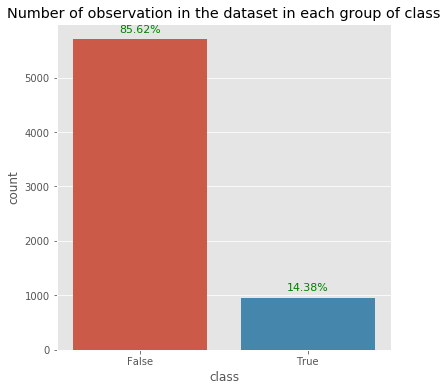

In [5]:
# Distribution of `class`
plt.figure(figsize = (6, 6));
g = sns.countplot(x = 'class', data = df)
plt.title('Number of observation in the dataset in each group of class');
ax = g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='green', rotation=0, xytext=(0, 10),
         textcoords='offset points') 

**Comment:** 

Obviously `class` = `False` accounts for large proportion in dataset with 85.62%. As a result, this is a problem of text classification with imbalanced classes, thus, accuracy is not a good metric evaluation. So, area under the receiver operation characteristic (ROC) curve (AUC) and F1-score is the main metric employed in this problem.

In [6]:
# Displaying some texts
for i in range(5):
    np.random.seed(i + 167)
    print(f'TEXT {i + 1}: {df.iloc[np.random.randint(len(df)), 0]} \n')

TEXT 1: entreprises de terrassement     

TEXT 2: entreprises d electricite generale     

TEXT 3: serrurerie  metallerie ouvrages commandes en fer forge creation d objets decoratifs reparation de machines agricoles pose de portes  de portails  de gardes corps boutique en ligne devis gratuit produits portails sur mesure defenses de fenetres gardes corps artisan  forts de 10 ans d experience dans la serrurerie et la metallerie  nous intervenons pour la realisation de vos portails traditionnels ou personnalises nous vous invitons aussi a connaitre gaston  l escargot bourguignon   une mascotte qui voyage partout et qui est fabriquee artisanalement le totem peut trouver sa place a la maison  au bureau ou meme au jardin  

TEXT 4: pose  entretien  vitrification de parquets entretien de parquet cire nettoyage  poncage de parquet pose de parquet stratifie  de plancher flottant renovation de plancher  de parquet vente de parquet vitrification de parquet ancien marques blanchon bona produits pa

**Comment:** 

These texts seem to be used to describe the differences, tasks, user manual guide in the field of DIY (Do-it-yourself) and interior works. However, these texts had been pre-processed so it is difficult to understand the specific content. The punctuation and emphasis accent (these texts are in french) had been removed, but there are much white space and stop word such as à, de, d', l', etc. So, several cleaning text step are taken as tokenizing, removing stopwords and lemmatizing.

In [7]:
# Function to clean texts
def clean(x):   
    x = word_tokenize(x) #tokenizing
    x = [word for word in x if not word in stopwords.words('french')] #removing stopwords
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    x = [regex.sub('', word) for word in x if not regex.sub('', word) == ''] #removing punctuation
    wordnet = WordNetLemmatizer()
    x = [wordnet.lemmatize(word) for word in x] #lemmatizing
    return ' '.join(x)

In [8]:
# Cleaning text
df['cleaned_text'] = df['description'].apply(clean)

In [9]:
# Displaying these texts above after cleaning
for i in range(5):
    np.random.seed(i + 167)
    print(f'TEXT {i + 1}: {df.iloc[np.random.randint(len(df)), 2]} \n')

TEXT 1: entreprises terrassement 

TEXT 2: entreprises electricite generale 

TEXT 3: serrurerie metallerie ouvrages commandes fer forge creation objets decoratifs reparation machine agricoles pose porte portails gardes corp boutique ligne devi gratuit produits portails mesure defense fenetres gardes corp artisan fort 10 an experience serrurerie metallerie intervenons realisation portails traditionnels personnalises invitons aussi a connaitre gaston escargot bourguignon mascotte voyage partout fabriquee artisanalement totem peut trouver place a maison bureau meme jardin 

TEXT 4: pose entretien vitrification parquet entretien parquet cire nettoyage poncage parquet pose parquet stratifie plancher flottant renovation plancher parquet vente parquet vitrification parquet ancien marque blanchon bona produits parquet ancien bambou colle contrecolle escalier exterieur massif pvc parquet stratifie terrasse plancher bambou stratifie flottant teck chene chene massif qualibat pose entretien vitri

In [10]:
# Creating dictionary containing all words and their frequencies 
text = ' '.join(df['cleaned_text'].values)
dic = FreqDist(text.split(' '))

In [11]:
print(f'Number of different words in dataset: {len(dic)}')

Number of different words in dataset: 8177


In [12]:
# Top 20 highest frequency words
sorted(dic.items(), key=lambda y: y[1], reverse = True)[:20]

[('entreprises', 4899),
 ('installation', 3418),
 ('a', 3234),
 ('travaux', 2411),
 ('pose', 2378),
 ('menuiserie', 2098),
 ('vente', 2071),
 ('produits', 1840),
 ('porte', 1695),
 ('renovation', 1682),
 ('electricite', 1636),
 ('chauffage', 1586),
 ('peinture', 1570),
 ('depannage', 1401),
 ('generale', 1249),
 ('bois', 1163),
 ('isolation', 1083),
 ('le', 1071),
 ('maconnerie', 1057),
 ('couverture', 1050)]

(-0.5, 1199.5, 999.5, -0.5)

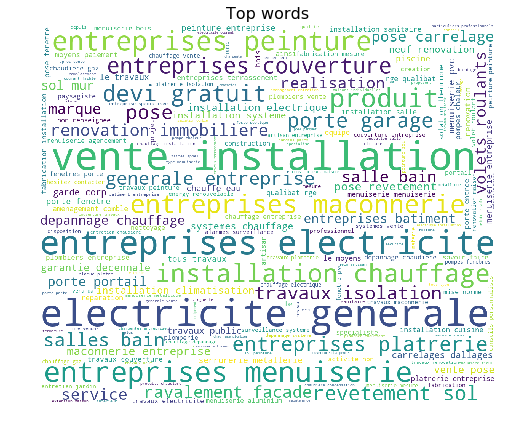

In [13]:
# Using WordCloud to look at most common words
fig, ax = plt.subplots(figsize = (10, 7))
text = ' '.join(df['cleaned_text'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words', fontsize = 16)
plt.axis("off")

Let's use ELI5 library for prediction explanation. I'll fit a basic vectorizer on desctriptions and build a simple Random Forest model. Then we will look at words which caused certain labels to be predicted.

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

vectorizer.fit(df['cleaned_text'].values)
X_train = vectorizer.transform(df['cleaned_text'].values)

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, df['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
for i in range(5):
    print(f'Text {i + 1}:')
    text = df.loc[df['class'] == False, 'cleaned_text'].values[np.random.randint(5000)]
    #print(text)
    display(eli5.show_prediction(rf, doc=text, vec=vectorizer, top=10))

Text 1:


Text 2:


Text 3:


Text 4:


Text 5:


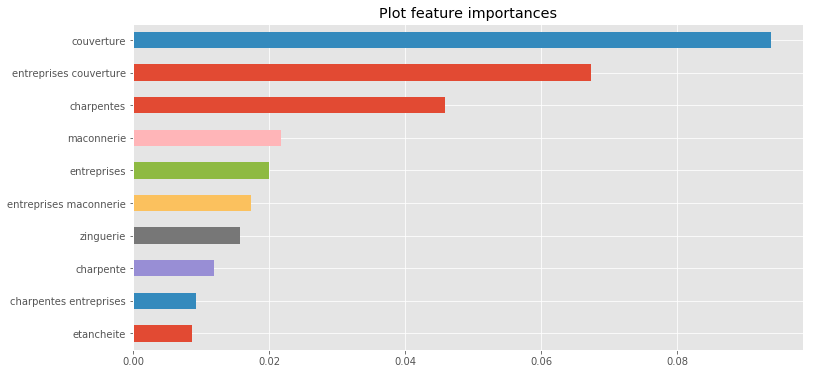

In [19]:
pd.Series(rf.feature_importances_, index = vectorizer.get_feature_names()).nlargest(10).sort_values().plot.barh(figsize = (12, 6), title = 'Plot feature importances')

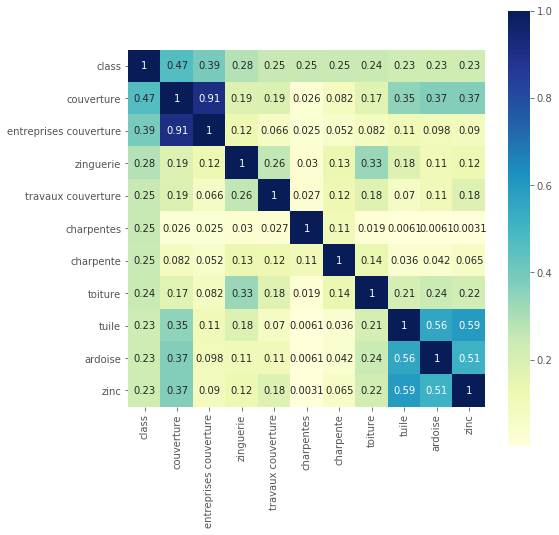

In [93]:
# Plot highest features' correlation with `class`
df_rf = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names())
corr_class = pd.Series()
for col in df_rf.columns:
    corr_class = corr_class.append(pd.Series(df['class'].corr(df_rf[col]), index = [col]))
top10 = corr_class.abs().nlargest(10).index.tolist()

# Perform matrix correlation
corrmat = pd.concat([df['class'], df_rf[top10]], axis = 1).corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, square = True, annot=True, cmap="YlGnBu");

**Comment:** 

By printing 5 random text, the word `couverture` always appears on the list of word having highest contribution to classes. The above plot of importance features and matrix correlation also confirm that. 

We try to build a simple model:
- si le mot “couverture” est présent, alors la classe est positive
- si le mot “couverture” est absent, alors la classe est négative.

In [25]:
conf = confusion_matrix(df['class'], df['cleaned_text'].str.contains('couverture'))
print('Confusion matrix:')
print(conf)
print(f'\nAccuracy: {np.sum(np.diag(conf))*100/np.sum(conf):.2f}%')

Confusion matrix:
[[5661   44]
 [ 561  397]]

Accuracy: 90.92%


**Comment:** 

This results is much impressive with the accuracy is over 90%, however, it's also noted that this is an imbalanced classes problem while all classes are assigned as lable `False`, we can achieve 85% accuracy. In whatever way, `couverture` is confirmed as one of key word in this problem.

## 2. Objective of the study

- **Problem**:
The objective of this study is to predict the target variable `class` with respect to `description` texts.

- **Evaluation metrics**:
ROC-AUC, F1-score and Accuracy metrics between the predicted value and the true value are employed in this study.

- **Validation method**:
The idea of validation method is to split this database into training and test datasets while test sets account for 20% of database. In the training set, 5-fold cross validation is used to tune hyperparameters and evaluate the models' results. And finally, the target variable is predicted on the test sets and then evaluate the results.

- **Models chosen**:
In this study, 2 groups of model: Neural Network (logistic regression with regularization, deep architecture with sequence model LSTM) and Tree-based models (bagging/boosting ensemble) are employed.

## 3. Features engineering

### 3.1. TF-IDF and SVD features

In [26]:
# Feature extraction using TfidfVectorizer to find (at least) four letter tokens, remove tokens that don't appear in at least 5 documents
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1, 4), token_pattern='(?u)\\b\\w\\w\\w+\\b').fit(df['cleaned_text'])

In [27]:
print(f'There are {len(tfidf.get_feature_names())} (group) words in the vocabulary')

There are 10026 (group) words in the vocabulary


In [28]:
# Displaying some words in the vocab
for i in range(5):
    print(tfidf.get_feature_names()[np.random.randint(10000)])

generale travaux electricite
installation spa sauna
terrassement entreprises demolition
parquet escalier
monument funeraire


In [29]:
# Transforming from text to array tfidf features
X_tfidf = tfidf.transform(df['cleaned_text']).toarray()

In [30]:
print(f'Shape of X_tfidf = {X_tfidf.shape}')

Shape of X_tfidf = (6663, 10026)


As the dimension after extractng `tfidf` features is much large (over 10000) so, reduction dimention by PCA with n_components = 300 is taken place.

In [31]:
svd = TruncatedSVD(n_components = 300, random_state = 167).fit(X_tfidf)

In [32]:
print(f'Sum of proportion information remaining: {np.sum(svd.explained_variance_ratio_)*100:.2f}%')

Sum of proportion information remaining: 76.54%


Proportion of information remaining is higher than 75%, it's quite good enough comparing with the number of chosen components!!!

In [33]:
# Adding them to our database
df = pd.concat([df, pd.DataFrame(svd.transform(X_tfidf), columns = [f'SVD_{i + 1}' for i in range(300)])], axis = 1)

### 3.2. Statistical Features

In this section, I consider several features of description such as: number of characters, number of words, number of different words, number of digits, number of non-words, average characters per word.

In [34]:
df['nb_characters'] = df['cleaned_text'].str.len()
df['nb_words'] = df['cleaned_text'].str.split().str.len()
df['nb_diff_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))
df['nb_digits'] = df['cleaned_text'].str.count(r'\d')
df['nb_non_words'] = df['cleaned_text'].str.count(r'\W')
df['avg_characters_per_word'] = (df['nb_characters'] - df['nb_non_words'])/df['nb_words']

In [35]:
def plot_dist(col):
    fig, ax = plt.subplots(1, 2, figsize = (14, 6), sharey = True)
    sns.boxplot(x = 'class', y = col, data = df, ax = ax[0])
    sns.violinplot(x = 'class', y = col, data = df, ax = ax[1])
    plt.suptitle(f'Distribution of {col} w.r.t class', fontsize = 15)
    return plt.show()

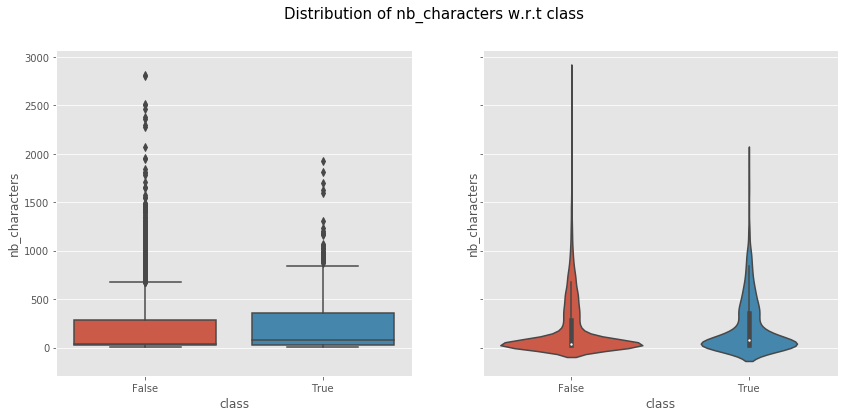

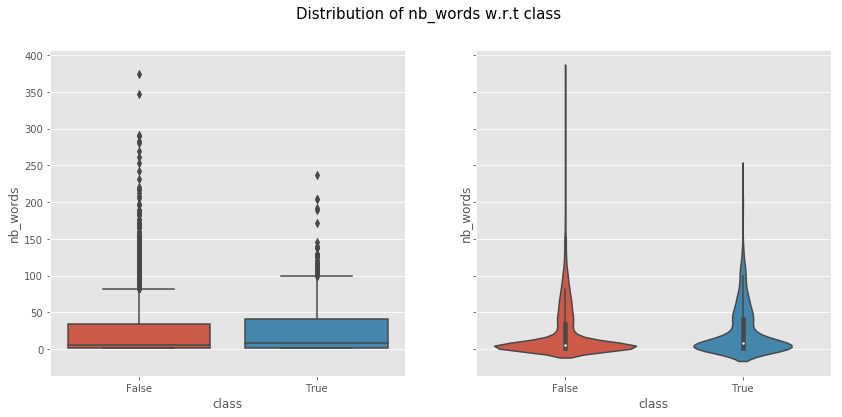

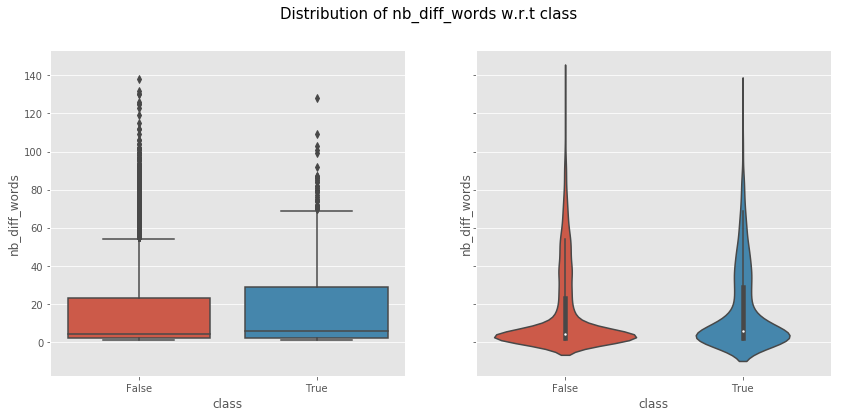

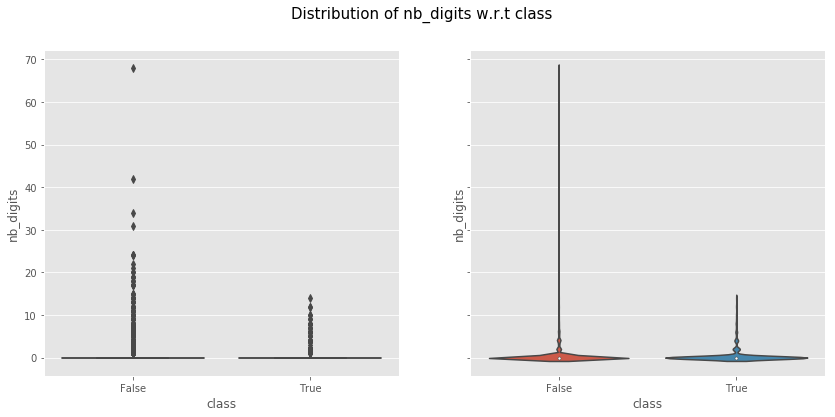

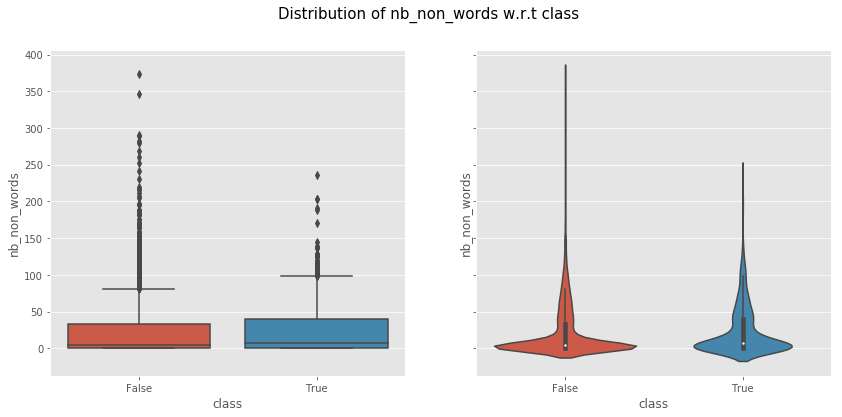

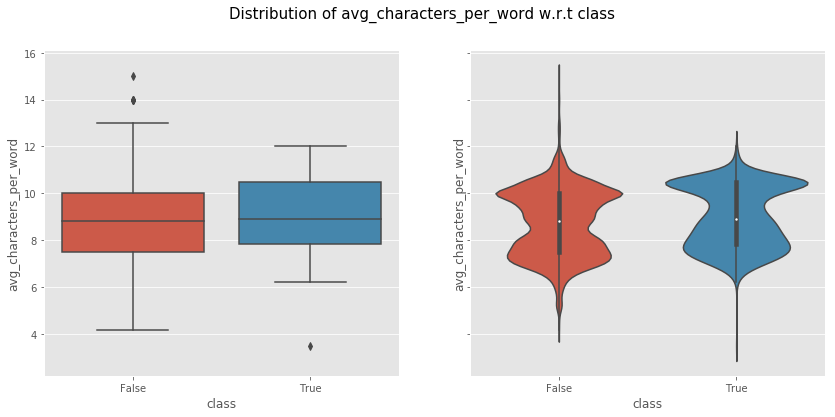

In [37]:
# Plot distribution of these features
for col in df.columns[-6:]:
    plot_dist(col)

**Comment:** 

The distributions of these features in each class seem to be similar in mean/median/mode but their variances in class `True` is higher than it in class `False`. This can be explained as small database in class `True`, so this comparison may be not exact.

In [39]:
# Split data into training and test sets
train, test = train_test_split(df, test_size = 0.2, random_state = 167)

In [40]:
X_train = train.iloc[:, 3:]
X_test = test.iloc[:, 3:]
Y_train = train['class']
Y_test = test['class']
text_train = train['cleaned_text']
text_test = test['cleaned_text']

## 4. Model selection

### 4.1. Logistic Regression

In [19]:
# Tuning hyper-parameters by GridSearchCV
params = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]}
logit = GridSearchCV(LogisticRegression(solver = 'lbfgs', max_iter = 10000), param_grid = params, cv = 5, scoring = 'roc_auc')
logit.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
logit.best_params_

{'C': 3}

In [21]:
logit.best_score_

0.9105595287260331

In [22]:
print('Accuracy of Logistic Regression model on test set: {:.2f}%'.format(accuracy_score(Y_test, logit.predict(X_test))*100))
print('F1 Score of Logistic Regression model on test set: {:.2f}'.format(f1_score(Y_test, logit.predict(X_test))))
print('AUC of Logistic Regression model on test set: {:.2f}'.format(roc_auc_score(Y_test, logit.predict_proba(X_test)[:, 1])))

Accuracy of Logistic Regression model on test set: 91.07%
F1 Score of Logistic Regression model on test set: 0.57
AUC of Logistic Regression model on test set: 0.89


In [ ]:
def plot_roc_curve(clf):
    fpr, tpr, _ = roc_curve(Y_test.values, clf.predict_proba(X_test.values)[:, 1])
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize = (6, 6))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    ax.plot(fpr, tpr, lw=3, label = 'ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    ax.set_aspect('equal')
    return plt.show()

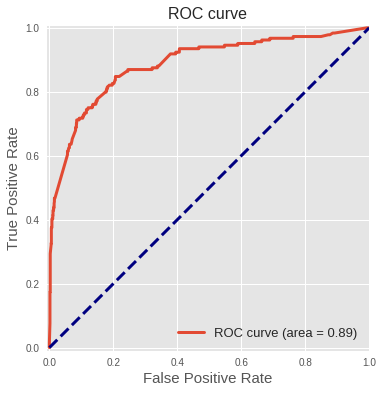

In [23]:
plot_roc_curve(logit)

In [ ]:
results = pd.DataFrame(columns = ['Model', 'ACC_train', 'ACC_test', 'F1_train', 'F1_test', 'AUC_train', 'AUC_test'])

In [0]:
results.loc[len(results), :] = ['Logistic Regression', accuracy_score(Y_train, logit.predict(X_train)), accuracy_score(Y_test, logit.predict(X_test)),
f1_score(Y_train, logit.predict(X_train)), f1_score(Y_test, logit.predict(X_test)),
roc_auc_score(Y_train, logit.predict_proba(X_train)[:, 1]), roc_auc_score(Y_test, logit.predict_proba(X_test)[:, 1])] 

### 4.2. Random Forest

In [0]:
# Preparing hyper-parameters for tuning
max_depth = [int(x) for x in np.linspace(3, 50, num = 5)]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2, 5]

# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [0]:
# Tuning hyper-parameters by RandomizedSearchCV
rf = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators = 500, bootstrap = True, max_features = 'sqrt'), param_distributions = random_grid, cv = 5, scoring = 'roc_auc', verbose=2, random_state = 167, n_jobs = -1)
rf.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 14, 26, 38, 50], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 5]},
          pre_dispatch='2*n_jobs', random_state=167, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [0]:
rf.best_params_

{'max_depth': 38, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [0]:
rf.best_score_

0.8949518978754711

In [25]:
rf = RandomForestClassifier(max_depth = 38, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 500, max_features = 'sqrt', bootstrap = True)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=38, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
print('Accuracy of Random Forest model on test set: {:.2f}%'.format(rf.score(X_test, Y_test)*100))
print('F1 Score of Random Forest model on test set: {:.2f}'.format(f1_score(Y_test, rf.predict(X_test))))
print('AUC of Random Forest model on test set: {:.2f}'.format(roc_auc_score(Y_test, rf.predict_proba(X_test)[:, 1])))

Accuracy of Random Forest model on test set: 91.00%
F1 Score of Random Forest model on test set: 0.55
AUC of Random Forest model on test set: 0.87


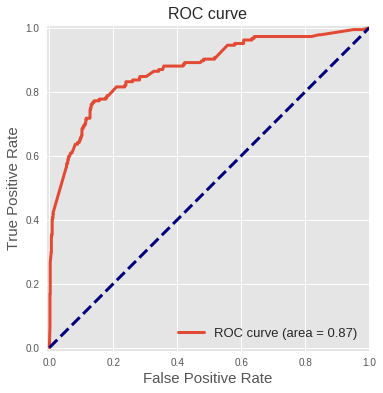

In [27]:
plot_roc_curve(rf)

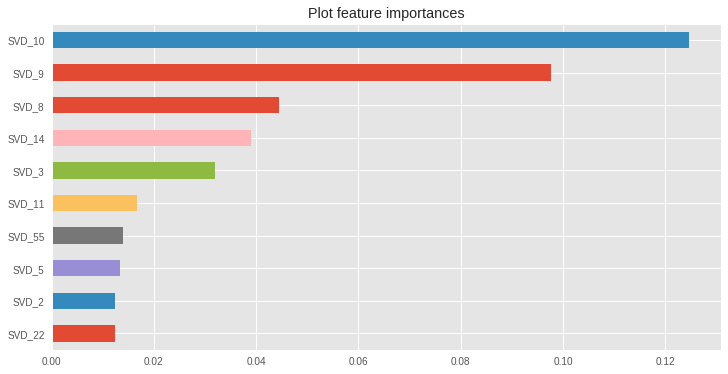

In [28]:
pd.Series(rf.feature_importances_, index = X_train.columns).nlargest(10).sort_values().plot.barh(figsize = (12, 6), title = 'Plot feature importances')

In [0]:
results.loc[len(results), :] = ['Random Forest', accuracy_score(Y_train, rf.predict(X_train)), accuracy_score(Y_test, rf.predict(X_test)),
f1_score(Y_train, rf.predict(X_train)), f1_score(Y_test, rf.predict(X_test)),
roc_auc_score(Y_train, rf.predict_proba(X_train)[:, 1]), roc_auc_score(Y_test, rf.predict_proba(X_test)[:, 1])] 

### 4.3. Gradient Boosting

In [0]:
# Preparing hyper-parameters for tuning
max_depth = [int(x) for x in np.linspace(3, 50, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [0]:
# Tuning hyper-parameters by RandomizedSearchCV
gb = RandomizedSearchCV(estimator = GradientBoostingClassifier(n_estimators = 500, max_features = 'sqrt'), param_distributions = random_grid, cv = 5, scoring = 'roc_auc', verbose=2, random_state = 167, n_jobs = -1)
gb.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 26, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=167, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [0]:
gb.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [0]:
gb.best_score_

In [30]:
gb = GradientBoostingClassifier(n_estimators = 500, max_features = 'sqrt', max_depth = 3, min_samples_leaf = 1, min_samples_split = 2)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [31]:
print('Accuracy of Gradient Boosting model on test set: {:.2f}%'.format(gb.score(X_test, Y_test)*100))
print('F1 Score of Gradient Boosting model on test set: {:.2f}'.format(f1_score(Y_test, gb.predict(X_test))))
print('AUC of Gradient Boosting model on test set: {:.2f}'.format(roc_auc_score(Y_test, gb.predict_proba(X_test)[:, 1])))

Accuracy of Gradient Boosting model on test set: 90.47%
F1 Score of Gradient Boosting model on test set: 0.55
AUC of Gradient Boosting model on test set: 0.88


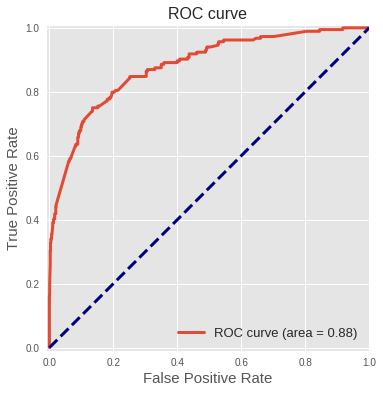

In [32]:
plot_roc_curve(gb)

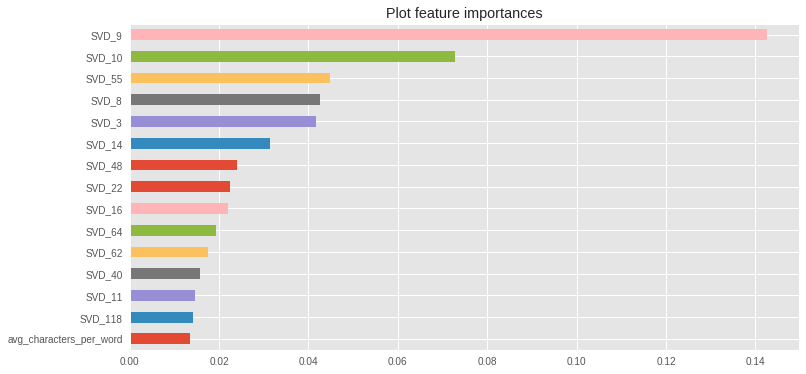

In [58]:
pd.Series(gb.feature_importances_, index = X_train.columns).nlargest(15).sort_values().plot.barh(figsize = (12, 6), title = 'Plot feature importances')

In [0]:
results.loc[len(results), :] = ['Gradient Boosting', accuracy_score(Y_train, gb.predict(X_train)), accuracy_score(Y_test, gb.predict(X_test)),
f1_score(Y_train, gb.predict(X_train)), f1_score(Y_test, gb.predict(X_test)),
roc_auc_score(Y_train, gb.predict_proba(X_train)[:, 1]), roc_auc_score(Y_test, gb.predict_proba(X_test)[:, 1])] 

### 4.4. Light GBM

In [46]:
# Tuning hyper-parameters by GridSearchCV
param_grid = {'max_depth': [int(x) for x in np.linspace(3, 30, 3)],
              'num_leaves': [int(x) for x in np.arange(10, 100, 30)],
              'lambda': [1e-2, 0.1, 1]}
lightgbm = GridSearchCV(estimator = lgb.LGBMClassifier(metric = 'auc', learning_rate = 0.1, n_estimators = 500, feature_fraction = 0.8, 
                                                 bagging_fraction = 0.8), param_grid = param_grid, 
                                                 scoring = 'roc_auc', n_jobs = -1, verbose = 2, iid = False, cv = 5)
lightgbm.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 38.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.8,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0..._lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 16, 30], 'num_leaves': [10, 40, 70], 'lambda': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [47]:
lightgbm.best_params_

{'lambda': 1, 'max_depth': 3, 'num_leaves': 10}

In [48]:
lightgbm.best_score_

0.8839338762799753

In [50]:
lightgbm = lgb.LGBMClassifier(metric = 'auc', learning_rate = 0.1, n_estimators = 500, feature_fraction = 0.8, 
                              bagging_fraction = 0.8, max_depth = 3, num_leaves = 10, reg_lambda = 1, n_jobs = -1)
lightgbm.fit(X_train, Y_train)

LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.8,
        importance_type='split', learning_rate=0.1, max_depth=3,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=10,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=1,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [51]:
print('Accuracy of LightGBM model on test set: {:.2f}%'.format(lightgbm.score(X_test, Y_test)*100))
print('F1 Score of LightGBM model on test set: {:.2f}'.format(f1_score(Y_test, lightgbm.predict(X_test))))
print('AUC of LightGBM model on test set: {:.2f}'.format(roc_auc_score(Y_test, lightgbm.predict_proba(X_test)[:, 1])))

Accuracy of LightGBM model on test set: 90.70%
F1 Score of LightGBM model on test set: 0.56
AUC of LightGBM model on test set: 0.86


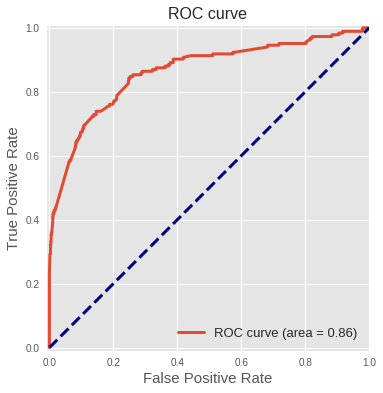

In [52]:
plot_roc_curve(lightgbm)

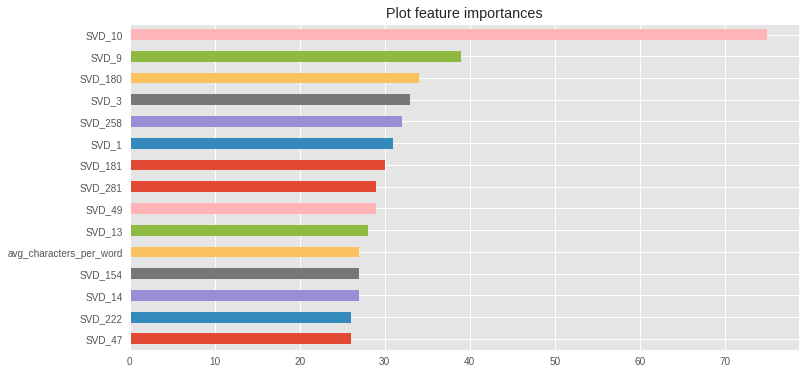

In [56]:
pd.Series(lightgbm.feature_importances_, index = X_train.columns).nlargest(15).sort_values().plot.barh(figsize = (12, 6), title = 'Plot feature importances')

In [0]:
results.loc[len(results), :] = ['Light GBM', accuracy_score(Y_train, lightgbm.predict(X_train)), accuracy_score(Y_test, lightgbm.predict(X_test)),
f1_score(Y_train, lightgbm.predict(X_train)), f1_score(Y_test, lightgbm.predict(X_test)),
roc_auc_score(Y_train, lightgbm.predict_proba(X_train)[:, 1]), roc_auc_score(Y_test, lightgbm.predict_proba(X_test)[:, 1])] 

### 4.5. XGBoost

In [63]:
# Tuning hyper-parameters by GridSearchCV
param_grid = {'max_depth': [int(x) for x in np.linspace(3, 30, 3)],
              'min_child_weight': [1, 3, 5],
              'reg_lambda': [1e-2, 0.1, 1]}
xgboost = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 500, colsample_bytree = 0.8, subsample = 0.6,
                                            nthread = 4, seed = 27), param_grid = param_grid, scoring = 'roc_auc',
                                            n_jobs = -1, verbose = 2, iid = False, cv = 5)
xgboost.fit(X_train.values, Y_train.values)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 59.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 16, 30], 'min_child_weight': [1, 3, 5], 'reg_lambda': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [64]:
xgboost.best_params_

{'max_depth': 3, 'min_child_weight': 5, 'reg_lambda': 1}

In [65]:
xgboost.best_score_

0.8829977505843921

In [66]:
xgboost = xgb.XGBClassifier(max_depth = 3, learning_rate = 0.1, n_estimators = 500, colsample_bytree = 0.8, n_jobs = -1,
                            min_child_weight = 5, reg_lambda = 1, subsample = 0.6, nthread = 4, seed = 27)
xgboost.fit(X_train.values, Y_train.values)  

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=500,
       n_jobs=-1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6)

In [77]:
print('Accuracy of XGBoost model on test set: {:.2f}%'.format(accuracy_score(Y_test.values, xgboost.predict(X_test.values))*100))
print('F1 Score of XGBoost model on test set: {:.2f}'.format(f1_score(Y_test, xgboost.predict(X_test.values))))
print('AUC of XGBoost model on test set: {:.2f}'.format(roc_auc_score(Y_test, xgboost.predict_proba(X_test.values)[:, 1])))

Accuracy of XGBoost model on test set: 90.62%
F1 Score of XGBoost model on test set: 0.56
AUC of XGBoost model on test set: 0.87


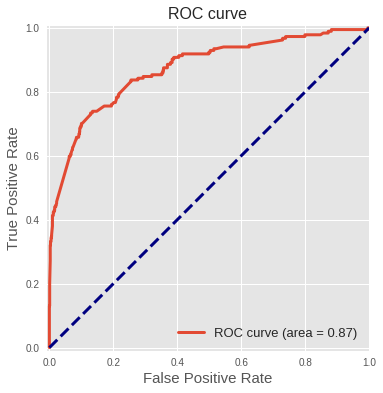

In [68]:
plot_roc_curve(xgboost)

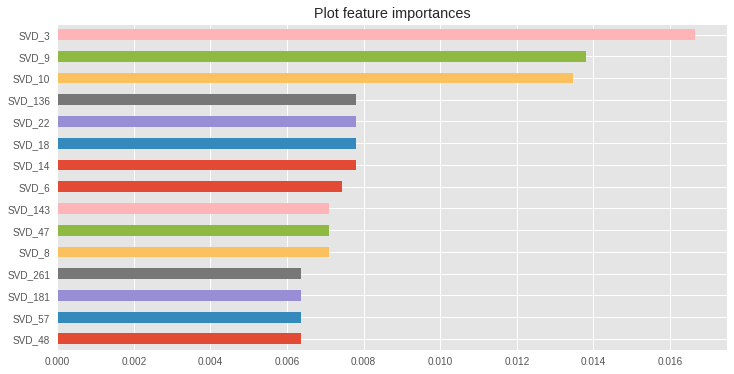

In [70]:
pd.Series(xgboost.feature_importances_, index = X_train.columns).nlargest(15).sort_values().plot.barh(figsize = (12, 6), title = 'Plot feature importances')

In [0]:
results.loc[len(results), :] = ['XGBoost', accuracy_score(Y_train, xgboost.predict(X_train.values)), accuracy_score(Y_test, xgboost.predict(X_test.values)),
f1_score(Y_train, xgboost.predict(X_train.values)), f1_score(Y_test, xgboost.predict(X_test.values)),
roc_auc_score(Y_train, xgboost.predict_proba(X_train.values)[:, 1]), roc_auc_score(Y_test, xgboost.predict_proba(X_test.values)[:, 1])] 

### 4.6. Neural Network

In [72]:
# Tuning hyper-parameters by GridSearchCV
params = {'hidden_layer_sizes': [(64, ), (128, ), (256, )]}
nn = GridSearchCV(MLPClassifier(max_iter = 10000), param_grid = params, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 2, iid = False)
nn.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(64,), (128,), (256,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [73]:
nn.best_params_

{'hidden_layer_sizes': (64,)}

In [74]:
nn.best_score_

0.8965597596530832

In [78]:
print('Accuracy of Neural Network model on test set: {:.2f}%'.format(accuracy_score(Y_test, nn.predict(X_test))*100))
print('F1 Score of Neural Network model on test set: {:.2f}'.format(f1_score(Y_test, nn.predict(X_test.values))))
print('AUC of Neural Network model on test set: {:.2f}'.format(roc_auc_score(Y_test, nn.predict_proba(X_test.values)[:, 1])))

Accuracy of Neural Network model on test set: 90.77%
F1 Score of Neural Network model on test set: 0.58
AUC of Neural Network model on test set: 0.87


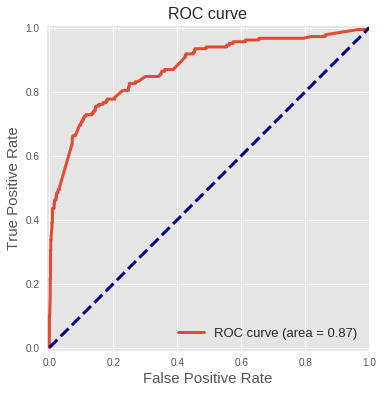

In [76]:
plot_roc_curve(nn)

In [0]:
results.loc[len(results), :] = ['Neural Network', accuracy_score(Y_train, nn.predict(X_train)), accuracy_score(Y_test, nn.predict(X_test)),
f1_score(Y_train, nn.predict(X_train)), f1_score(Y_test, nn.predict(X_test)),
roc_auc_score(Y_train, nn.predict_proba(X_train)[:, 1]), roc_auc_score(Y_test, nn.predict_proba(X_test)[:, 1])] 

### 4.7. Deep Neural Network with LSTM

We will try a combination of Numerical Features extracted from TF-IDF and original texts using Deep neural network and sequence model (RNN architecture, specially bidirectional LSTM model). Here is the model we will implement:

<img src="NNarchitecture.png" style="width:800px;height:400px;"> <br>
<caption><center> <b><u> Figure </b></u>: Deep Neural Network with LSTM. </center></caption>

In [83]:
import io
from tqdm import tqdm

# Loading pre-trained word vectors (300-dimensional vectors) for French (https://fasttext.cc/docs/en/crawl-vectors.html)
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        if tokens[0] in dic.keys():
            data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data
embedding_index = load_vectors('../input/cc.fr.300.vec')

2000000it [01:16, 26093.53it/s]


In [81]:
# Importing some function from Keras
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling2D, GlobalMaxPooling1D, Conv1D, Concatenate, GRU, Reshape, PReLU, Bidirectional, CuDNNLSTM, SpatialDropout1D, LSTM, Dense, BatchNormalization, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, GlobalAveragePooling1D, Lambda, AveragePooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [84]:
max_len = 300 #Cuts off description after 300 words
max_words = len(dic)
embedding_dim = 300
# Tokenizing the text of the raw data
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
print(f'Number of different words in vocabulary: {len(word_index)}')

Number of different words in vocabulary: 7333


In [0]:
train_sequences = tokenizer.texts_to_sequences(text_train)
test_sequences = tokenizer.texts_to_sequences(text_test) 
# Turns the lists of integers into a 2D integer tensor of shape (samples, max_len)
X_train_text = pad_sequences(train_sequences, maxlen = max_len)
X_test_text = pad_sequences(test_sequences, maxlen = max_len)

In [0]:
# Preparing the FastText word-embeddings matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [0]:
# Building model
all_inputs = []

# text architecture
text_input = Input(shape = (max_len, ), name='text_input')
all_inputs.append(text_input)
x = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
              embedding_matrix.shape[1], # or EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False)(text_input)
x = SpatialDropout1D(0.25)(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=False))(x)
#x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
#avg_pool = GlobalAveragePooling1D()(x)
#max_pool = GlobalMaxPooling1D()(x)
#x = Concatenate()([avg_pool, max_pool])
x = Dropout(0.3)(x)
x = Dense(128, kernel_initializer='he_normal')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# numerical architecture 
numerical_input = Input(shape=(X_train.shape[1],), name='numerical')
all_inputs.append(numerical_input)
numerical_dense = Dense(64)(numerical_input) 
numerical_dense = PReLU()(numerical_dense)

# concatenate architecture  
x = Concatenate()([x, numerical_dense])
x = Dense(256, kernel_initializer='he_normal')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs=all_inputs, outputs=out)

In [91]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 300)     2453100     text_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 300, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 300, 512)     1142784     spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [0]:
model.compile(loss='binary_crossentropy', optimizer = Adam(lr = 0.01, decay = 0.01), metrics=['accuracy'])
check_point = ModelCheckpoint('NNmodel.hdf5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=5)

In [97]:
model.fit([X_train_text, X_train.values], Y_train.values, validation_data = ([X_test_text, X_test.values], Y_test.values), epochs = 30, 
          callbacks=[check_point, early_stop], batch_size = 512)

Train on 5330 samples, validate on 1333 samples
Epoch 1/30
5330/5330 [==============================] - 18s 3ms/step - loss: 0.2103 - acc: 0.9178 - val_loss: 0.2796 - val_acc: 0.8957

Epoch 00001: val_loss did not improve from 0.26508
Epoch 2/30
5330/5330 [==============================] - 17s 3ms/step - loss: 0.2058 - acc: 0.9159 - val_loss: 0.2588 - val_acc: 0.9100

Epoch 00002: val_loss improved from 0.26508 to 0.25880, saving model to NNmodel.hdf5
Epoch 3/30
5330/5330 [==============================] - 17s 3ms/step - loss: 0.2040 - acc: 0.9169 - val_loss: 0.2635 - val_acc: 0.9010

Epoch 00003: val_loss did not improve from 0.25880
Epoch 4/30
5330/5330 [==============================] - 17s 3ms/step - loss: 0.2096 - acc: 0.9161 - val_loss: 0.2629 - val_acc: 0.9010

Epoch 00004: val_loss did not improve from 0.25880
Epoch 5/30
5330/5330 [==============================] - 17s 3ms/step - loss: 0.2045 - acc: 0.9167 - val_loss: 0.2754 - val_acc: 0.9047

Epoch 00005: val_loss did not impr

In [0]:
model.load_weights('NNmodel.hdf5')

In [0]:
Y_train_proba = model.predict([X_train_text, X_train.values]).ravel()
Y_test_proba = model.predict([X_test_text, X_test.values]).ravel()

In [0]:
Y_train_pred = np.round(Y_train_proba)
Y_test_pred = np.round(Y_test_proba)

In [101]:
print('Accuracy of Deep Neural Network model on test set: {:.2f}%'.format(accuracy_score(Y_test, Y_test_pred)*100))
print('F1 Score of Deep Neural Network model on test set: {:.2f}'.format(f1_score(Y_test, Y_test_pred)))
print('AUC of Deep Neural Network model on test set: {:.2f}'.format(roc_auc_score(Y_test, Y_test_proba)))

Accuracy of Deep Neural Network model on test set: 91.00%
F1 Score of Deep Neural Network model on test set: 0.53
AUC of Deep Neural Network model on test set: 0.87


In [0]:
results.loc[len(results), :] = ['DeepNN LSTM', accuracy_score(Y_train, Y_train_pred), accuracy_score(Y_test, Y_test_pred),
f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred),
roc_auc_score(Y_train, Y_train_proba), roc_auc_score(Y_test, Y_test_proba)] 

### 4.8. Model comparison

In [105]:
results

,Model,ACC_train,ACC_test,F1_train,F1_test,AUC_train,AUC_test
0,Logistic Regression,0.921201,0.910728,0.650582,0.573477,0.938361,0.886544
1,Random Forest,0.932458,0.909977,0.707792,0.552239,0.963631,0.871992
2,Gradient Boosting,0.955159,0.904726,0.82204,0.548043,0.977778,0.880132
3,Light GBM,0.955347,0.906977,0.822917,0.560284,0.980246,0.864083
4,XGBoost,0.955347,0.906227,0.823442,0.56446,0.979222,0.871277
5,Neural Network,0.921764,0.907727,0.679477,0.580205,0.940371,0.873919
6,DeepNN LSTM,0.909006,0.909977,0.557078,0.53125,0.941591,0.874615


**Comment:**

- Logistic Regression gives the highest Accuracy and AUC in the test set, while these values calculated in the training set are quite low ( lowest AUC in training set among all models). Thus, the overfitting is reduced.

- Basic Neural Network with one hidden layer gives the highest F1-score in the test set, while its F1-score in training set is quite low comparing with the other models, so the overfitting problem is reduced.


## 5. Conclusion

- In general, group of models Neural Network give better performances in test sets, while group of tree-based model exhibits high overfitting. In real practice, we can set up different metrics based on the purposes and applied situation of the problem, then, we have appropriate models. However, in this problem, with better performances associated with the simplity and high-running-speed, the logistic regression model is likely to deploy in virtual reality, especially while the size of database explodes.

- LSTM network, one type of Recurrent Neural Networks (RNN) that are very effective for Natural Language Processing and other sequence tasks (because they have "memory") is employed but cannot give better results than other models. However, it can be noted that with this model, the evaluation metrics results in both training and test sets are similar, which means that overfitting has been reduced to the maximum. It could be explained by A bidirection LSTM remember some information/context through the hidden layer activations that get passed from one time-step to the next.

- As mentioned in EDA part, the appearance of the word `couverture` plays the most important role in almost models. Based on these above plots features importance, mainly, features tf-idf which had been reduced information plays an important role. This can be explained as such a basic problem, text classification by description is well solved by looking at what words occur in each description, and at what frequency. For some Statistical features of text, only average characters per word feature is one the top 15 in several tree-based models.

- In this study, I have implemented reduction information by choosing the number of components = 300. This allow to remain more than 75% information but we lost also much information. In the case of improving the proportion of remained information by increasing number of components, we may face with overfitting problem. In order to improve the result, we can tune number of components and run several different model, or unsqueeze the weights of embedding layer to do some fine-tuning, which require more and more resources.

